# Creating Helper Functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

# Function that takes a SQL query as an argument and returns a pandas dataframe of that query 
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
# Function that takes a SQL command as an argument and executes it using the sqlite module
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        # Tells SQLite to autocommit changes
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    q = '''
    SELECT 
        name,
        type
    FROM sqlite_master
    WHERE type IN("table","view");'''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Selecting Albums to Purchase

In [2]:
albums_to_purchase = '''
WITH usa_tracks_sold AS
   (
    SELECT il.* FROM invoice_line il
    INNER JOIN invoice i on il.invoice_id = i.invoice_id
    INNER JOIN customer c on i.customer_id = c.customer_id
    WHERE c.country = "USA"
   )

SELECT
    g.name genre,
    count(uts.invoice_line_id) tracks_sold,
    cast(count(uts.invoice_line_id) AS FLOAT) / (
        SELECT COUNT(*) from usa_tracks_sold
    ) percentage_sold
FROM usa_tracks_sold uts
INNER JOIN track t on t.track_id = uts.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;
'''
run_query(albums_to_purchase)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


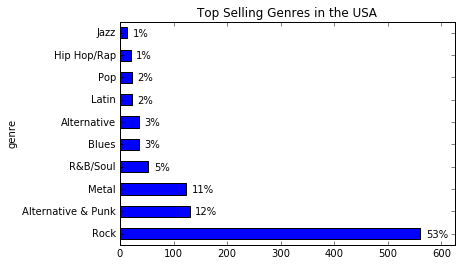

In [3]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre", inplace=True, drop=True)

genre_sales_usa["tracks_sold"].plot.barh(
    title="Top Selling Genres in the USA",
    xlim=(0, 625)
)

for i, label in enumerate(list(genre_sales_usa.index)):
    score = genre_sales_usa.loc[label, "tracks_sold"]
    label = (genre_sales_usa.loc[label, "percentage_sold"] * 100
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:
1) Red Tone (Punk)
2) Slim Jim Bites (Blues)
3) Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

# Analyzing Employee Sales Performance

In [4]:
employee_sales_performance = '''
WITH customer_support_rep_sales AS
    (
     SELECT i.customer_id,
            c.support_rep_id,
            SUM(i.total) total
     FROM invoice i
     INNER JOIN customer c ON c.customer_id = i.customer_id
     GROUP BY 1, 2
    )
    
SELECT e.first_name || " " || e.last_name employee,
       e.hire_date,
       SUM(csrs.total) total_sales
FROM customer_support_rep_sales csrs
INNER JOIN employee e ON e.employee_id = csrs.support_rep_id
GROUP BY employee;
'''

run_query(employee_sales_performance)

,employee,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


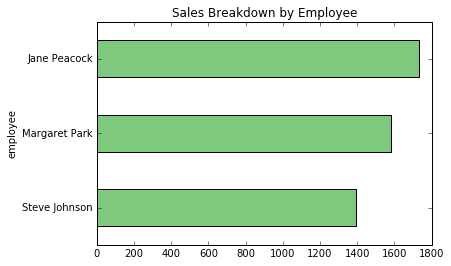

In [5]:
employee_sales = run_query(employee_sales_performance)
employee_sales.set_index("employee", drop=True, inplace=True)
employee_sales.sort_values("total_sales", inplace=True)

employee_sales.plot.barh(
    legend=False,
    title='Sales Breakdown by Employee',
    colormap=plt.cm.Accent
)
plt.show()

Jane Peacock has the most sales. However, she was hired earlier than Margaret and Steve, which explains the reason for the higher sales numbers

# Analyzing Sales by Country

In [8]:
sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / count(distinct customer_id) customer_lifetime_value,
        SUM(unit_price) / count(distinct invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

run_query(sales_by_country)

,country,customers,total_sales,average_order,customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


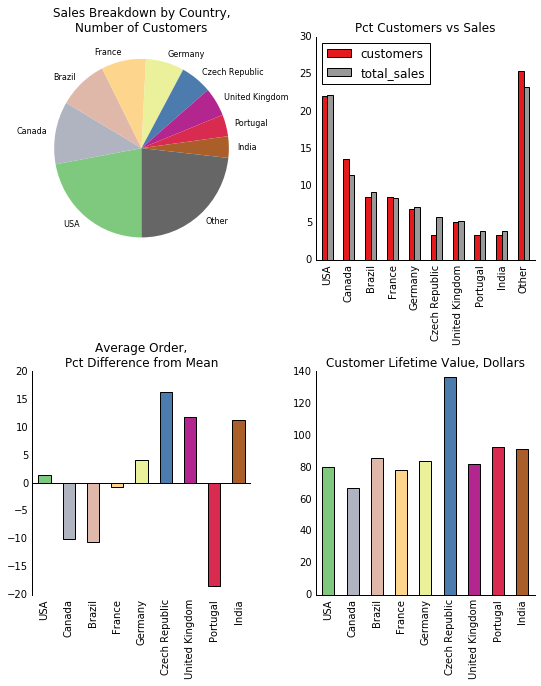

In [10]:
import numpy as np

# Visualizing Sales by Country
country_metrics = run_query(sales_by_country)
country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["average_order"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.drop("Other", inplace=True)
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

# bottom right
ltv = country_metrics["customer_lifetime_value"].copy()
ltv.index.name = ''
ltv.drop("Other",inplace=True)
ltv.plot.bar(
    ax=ax4,
    color=colors,
    title="Customer Lifetime Value, Dollars"
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")
ax4.spines["top"].set_visible(False)
ax4.spines["right"].set_visible(False)

plt.show()

# Albums vs Individual Tracks, Part 1

In [12]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                                     
                  EXCEPT 
                  
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,497,0.809446
1,yes,117,0.190554


# Albums vs Individual Tracks, Part 2

In [13]:
albums_vs_tracks_2 = '''
WITH invoice_first_track AS 
    (
     SELECT
         il.invoice_id invoice_id,
         i.customer_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     GROUP BY 1, 2
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                       ) percent
FROM
    (
    SELECT
        ifs.*,
        t.album_id,
        CASE
            WHEN
                (
                 SELECT t3.track_id FROM track t3
                 WHERE t3.album_id = t.album_id
                 
                 EXCEPT
                 
                 SELECT il2.track_id FROM invoice_line il2
                 INNER JOIN invoice i2 ON i2.invoice_id = il2.invoice_id
                 INNER JOIN track t2 ON t2.track_id = il2.track_id
                 WHERE
                         il2.invoice_id <= ifs.invoice_id
                     AND i2.customer_id = ifs.customer_id
                     AND t2.album_id = t.album_id

                ) IS NULL THEN "yes"
            ELSE "no"
        END AS "album_purchase"
    FROM invoice_first_track ifs
    INNER JOIN track t ON ifs.first_track_id = t.track_id
    )
GROUP BY 1
'''

run_query(albums_vs_tracks_2)

,album_purchase,number_of_invoices,percent
0,no,475,0.773616
1,yes,139,0.226384
